In [1]:
import sys
import numpy as np
np.set_printoptions(suppress=True, precision=4)
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,.4f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.metrics import log_loss, make_scorer
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import BinaryCrossentropy
from methods import *
import torch
import pickle, os
import skopt
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
import shutil
import warnings
warnings.filterwarnings("ignore")
print('done')

done


In [2]:
%load_ext autoreload
%autoreload 2
print('done')

done


# Explore dataset

In [ ]:
# path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-random_filters.csv'
# path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-random_filters.csv'
path_csv = fr'confusion-reports/conf_mat/round3-train-dataset_fc_square-30-gray_filters_h_kl.csv'
df = pd.read_csv(path_csv)
df.describe()

<AxesSubplot:>

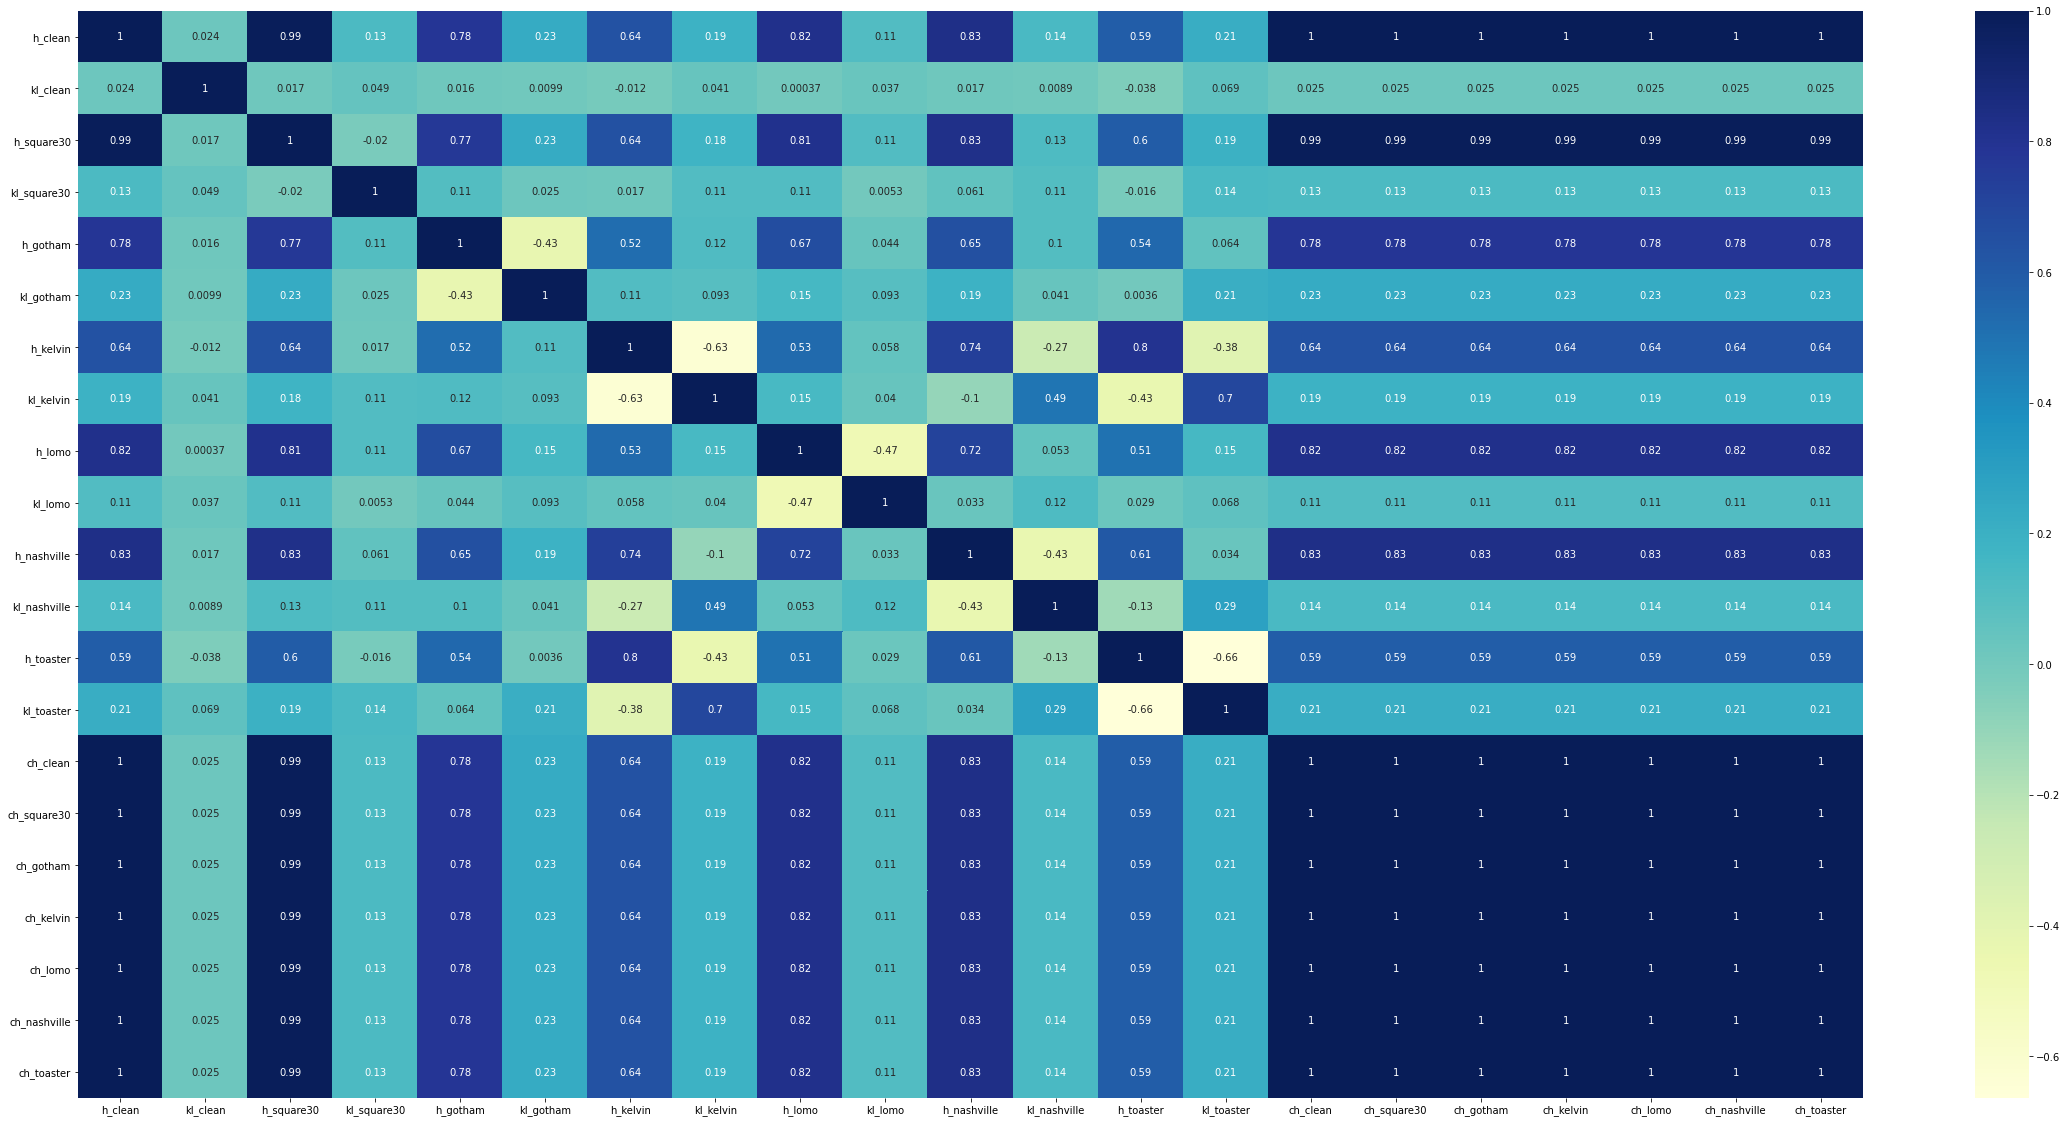

In [238]:
path_csv = fr'confusion-reports/conf_mat/round3-train-dataset_fc_square-30-random_filters_h_kl.csv'
df = pd.read_csv(path_csv)
labels = df['model_label']
for x in ['model_name', 'model_architecture', 'architecture_code', 'trigger_color', 'num_classes', 'trigger_type_aux']:
    del df[x]
for k in ['clean', 'square30', 'gotham', 'kelvin', 'lomo', 'nashville', 'toaster']:
    df[f'ch_{k}'] = df[f'h_{k}'] + df[f'kl_{k}']
#     del df[f'h_{k}'], df[f'kl_{k}']
plt.figure(figsize=(40,20)).patch.set_color('white')
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
# df.head()

selecting only polygons
Using hkl
(756, 14)
[('h_clean', 0.3218875824868201), ('kl_clean', 0.0), ('h_square30', 0.3218875824868201), ('kl_square30', 0.0), ('h_gotham', 0.2510458028209929), ('kl_gotham', 0.07084177966582719), ('h_kelvin', 0.3217875407784309), ('kl_kelvin', 0.00010004170838922403), ('h_lomo', 0.32148691313911154), ('kl_lomo', 0.0004006693477085474), ('h_nashville', 0.32088413503209795), ('kl_nashville', 0.0010034474547221683), ('h_toaster', 0.18570518471536274), ('kl_toaster', 0.13618239777145733)]


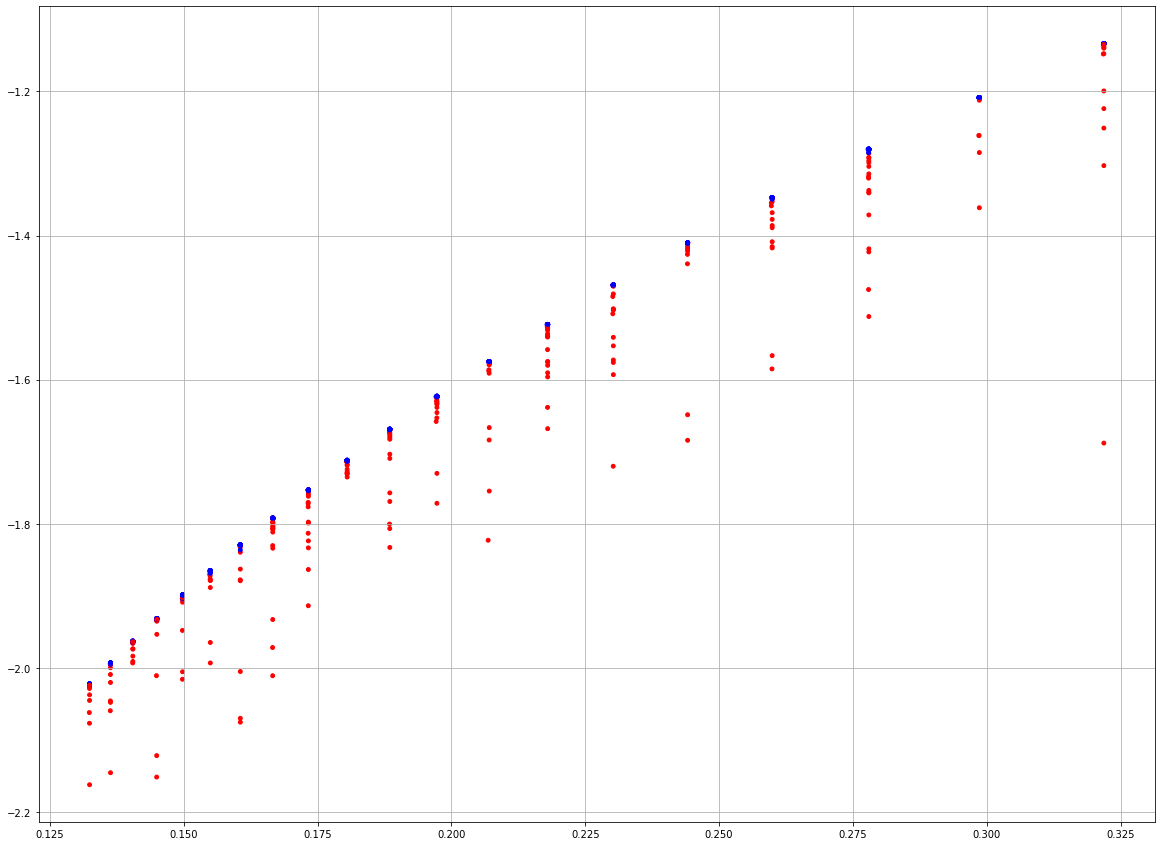

In [221]:
# path_csv = fr'confusion-reports/conf_mat/round3-train-dataset_fc_square-30-gray_filters_h_kl.csv'
path_csv = fr'confusion-reports/conf_mat/round3-train-dataset_fc_square-30-random_filters_h_kl.csv'
# path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-random_filters.csv'
X, y = read_features(path_csv, trigger_type_aux_str='polygon', arch=None, data='hkl', append_arch=False, arch_one_hot=False)
# X, y = read_features(path_csv, trigger_type_aux_str='polygon', arch=None, data='diffs', append_arch=False, arch_one_hot=False)
print(X.shape)
# X = StandardScaler().fit_transform(X)
arr = ['h_clean', 'kl_clean', 'h_square30', 'kl_square30', 'h_gotham', 'kl_gotham', 'h_kelvin', 'kl_kelvin', 'h_lomo', 'kl_lomo', 'h_nashville', 'kl_nashville', 'h_toaster', 'kl_toaster']
# arr = ['square30_r_mean_diff', 'square30_r_std_diff', 'gotham_mean_diff', 'gotham_std_diff', 'kelvin_mean_diff', 'kelvin_std_diff', 'lomo_mean_diff', 'lomo_std_diff', 'nashville_mean_diff', 'nashville_std_diff', 'toaster_mean_diff', 'toaster_std_diff']
print(list(zip(arr, X[0,:].tolist())))

i, j = arr.index('h_clean'), arr.index('h_square30')
# i, j = arr.index('square30_r_mean_diff'), arr.index('square30_r_std_diff')

f1, f2 = abs(X[:, i]), abs(X[:, j])
# f1 = np.log(f1)
f2 = np.log(f2)
plt.figure(figsize=(20,15)).patch.set_color('white')
plt.scatter(f1, f2, c=[['blue', 'red'][vy] for vy in y], s=15.0)
# plt.legend()
plt.grid()
# Good results for H+KL:
# indexes=3,4, log(|f1|), log(|f2|), h+kl (kl_square30, h_gotham)
# indexes=3,5 (kl_square30, kl_gotham)
# indexes=3,5 (kl_square30, kl_toaster)

# with standardization:
# 3, 4, log f1, log f2

## Correlation Plot

(166, 20)
model_name            id-00000001
model_architecture        vgg16bn
architecture_code               7
model_label                     0
trigger_type_aux             none
h_clean                    0.3219
kl_clean                   0.0000
h_square30                 0.3219
kl_square30                0.0000
h_gotham                   0.2510
kl_gotham                  0.0708
h_kelvin                   0.3218
kl_kelvin                  0.0001
h_lomo                     0.3215
kl_lomo                    0.0004
h_nashville                0.3209
kl_nashville               0.0010
h_toaster                  0.1857
kl_toaster                 0.1362
trigger_color              random
Name: 1, dtype: object


<AxesSubplot:>

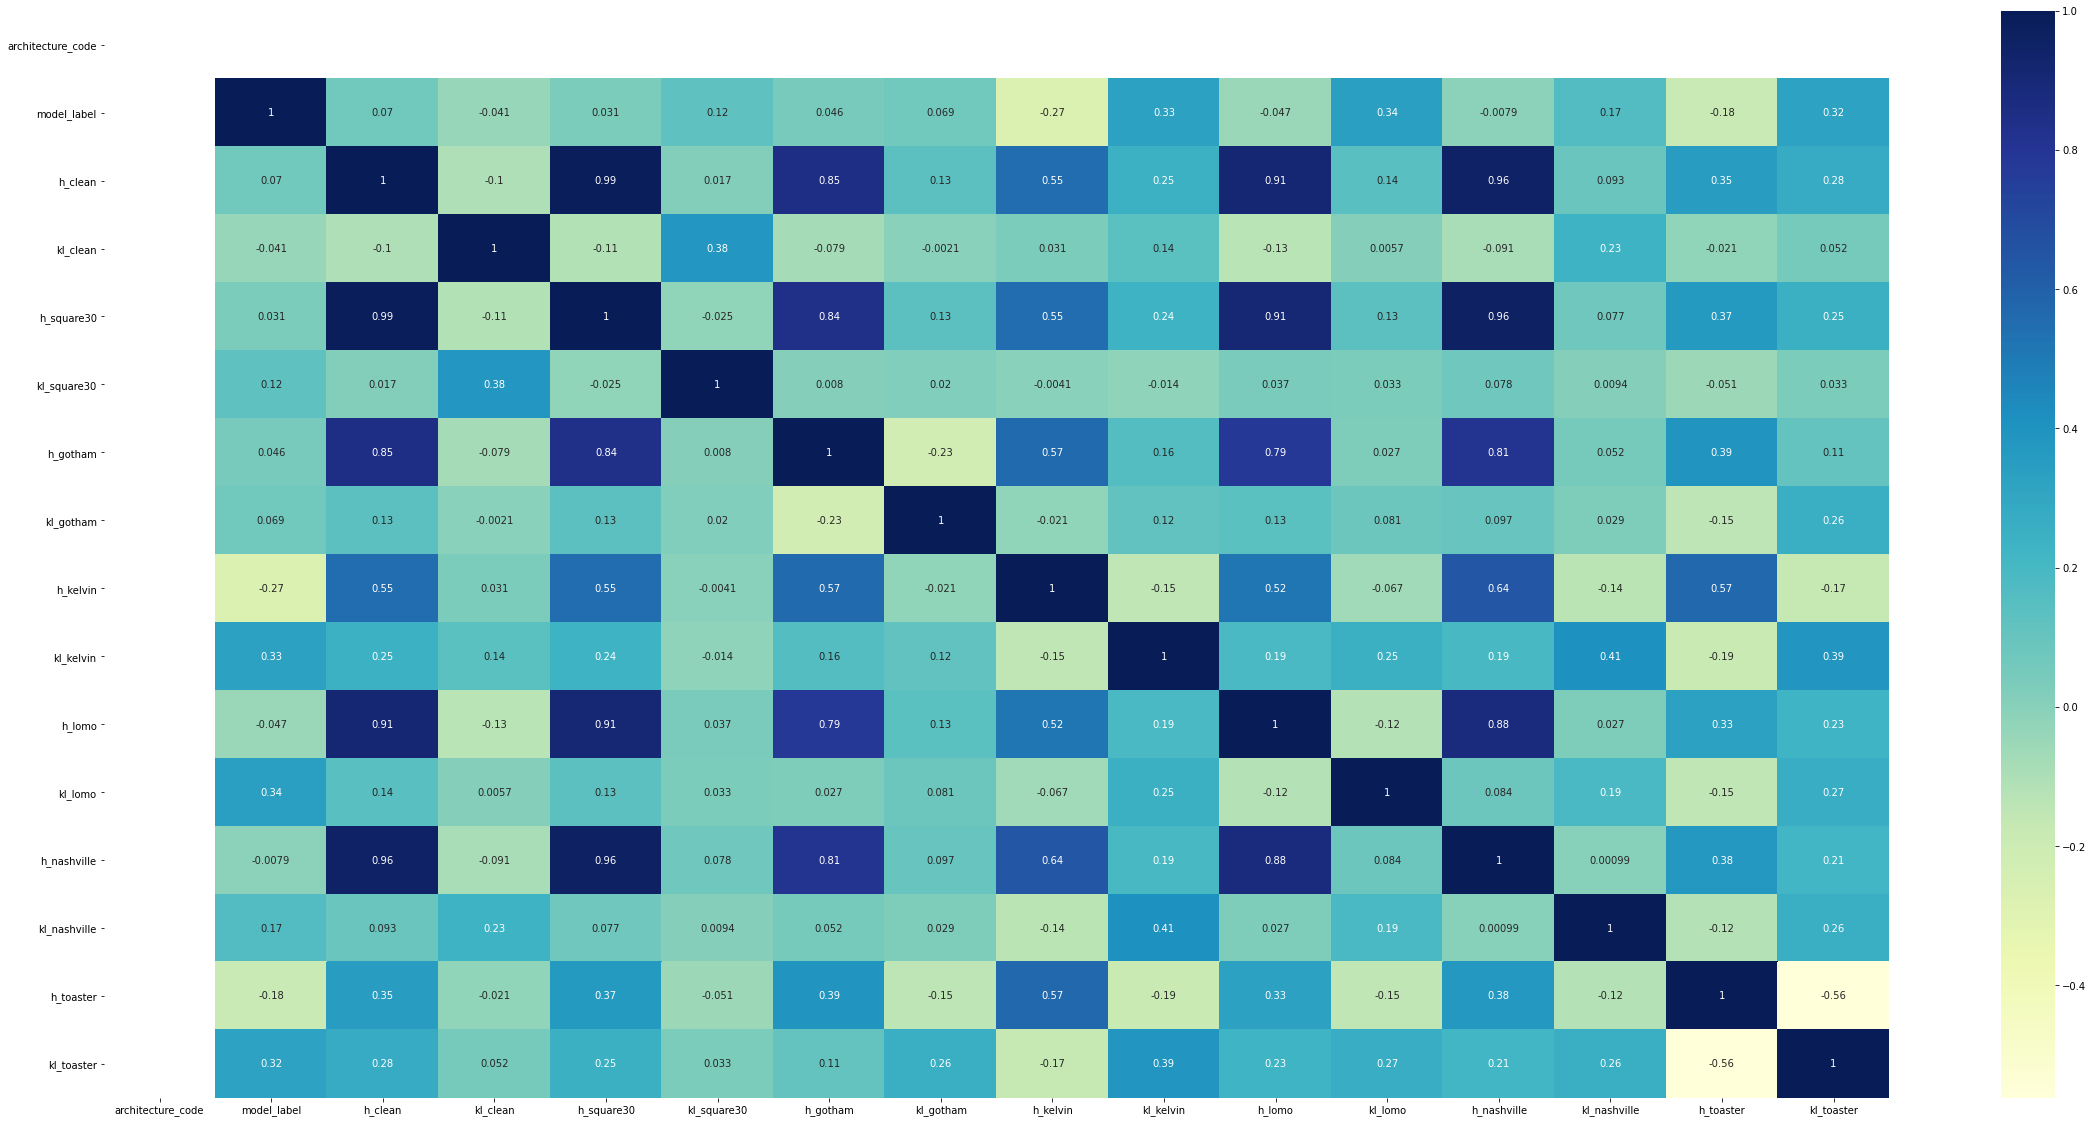

In [242]:
# path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-filters_all-classes_gray.csv'
# path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-gray_filters.csv'
# path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-random_filters.csv'
# path_csv = fr'confusion-reports/conf_mat/round3-train-dataset_fc_square-30-gray_filters_h_kl.csv'
path_csv = fr'confusion-reports/conf_mat/round3-train-dataset_fc_square-30-random_filters_h_kl.csv'
df = pd.read_csv(path_csv)
df = df[df['model_architecture'].str.contains('vgg')]
df['model_label'] = 1 - df['model_label'].astype('category').cat.codes
del df['num_classes']
indexes = []
arch = None
if arch is not None:
    for i in range(len(df)):
        if df['model_architecture'].iloc[i].startswith(arch):
            indexes.append(i)
    df = df.iloc[indexes]
for c in df.columns:
    if c.endswith('mean') or c.endswith('std'):# or c.startswith('h'):
#     if c.endswith('diff'):
        del df[c]
print(df.shape)
print(df.iloc[0])

for k in ['clean', 'square30', 'gotham', 'kelvin', 'lomo', 'nashville', 'toaster']:
    df[f'kl_{k}'] = np.log(df[f'kl_{k}'])
    df[f'h_{k}'] = np.log(df[f'h_{k}'])

plt.figure(figsize=(40,20)).patch.set_color('white')
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')

# plt.figure(figsize=(30,12)).patch.set_color('white')
# sns.pairplot(df, hue='model_label')

## Box-plots

In [ ]:
# path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-filters_all-classes_gray.csv'
# path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-gray_filters.csv'
path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-random_filters.csv'
# path_csv = fr'confusion-reports/conf_mat/round3-train-dataset_fc_square30-gray_filters_h_kl.csv'
df = pd.read_csv(path_csv)
df['model_label'] = 1 - df['model_label'].astype('category').cat.codes
del df['num_classes'], df['model_name']
indexes = []
arch = None
if arch is not None:
    for i in range(len(df)):
        if df['model_architecture'].iloc[i].startswith(arch):
            indexes.append(i)
    df = df.iloc[indexes]
for c in df.columns:
    if c.endswith('mean') or c.endswith('std'):
#     if c.endswith('diff'):
        del df[c]
del df['model_architecture'], df['architecture_code'], df['trigger_type_aux'], df['trigger_color']#, df['model_label']
print(df.columns.tolist())
for c in df.columns:
#     if c.startswith('h'):
    if c.endswith('mean_diff'):
        plt.figure().patch.set_color('white')
        sns.boxplot(x="model_label", y=c, hue="model_label", data=df, palette="Set3")
print('done')

In [ ]:
# path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-filters_all-classes_gray.csv'
path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-gray_filters.csv'
df = pd.read_csv(path_csv)
df['model_label'] = 1 - df['model_label'].astype('category').cat.codes
indexes = []
arch = None
if arch is not None:
    for i in range(len(df)):
        if df['model_architecture'].iloc[i].startswith(arch):
            indexes.append(i)
    df = df.iloc[indexes]
for c in df.columns:
    if c.endswith('mean') or c.endswith('std'):
#     if c.endswith('diff'):
        del df[c]
del df['model_architecture'], df['trigger_type_aux'], df['trigger_color'], df['num_classes'], df['model_name']
# print(df.head())

data = df.values
X, y = data[:, 1:], data[:, 0]
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X)
mask = np.where(yhat == 1)[0]
print(mask.shape)
del df['model_label']
plt.figure(figsize=(30, 12)).patch.set_color('white')
df.iloc[mask].boxplot()

# Stratified K-fold validation for a full training dataset (square-size and 5 filters)

In [26]:
n_splits = 10
n_repeats = 5

for size in [30]: #[10, 15, 20, 25, 30, 35, 40, 45, 50]:
#     path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-{size}_filters.csv'
#     path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-{size}-random_filters.csv'
#     path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-{size}-gray_filters.csv'
#     path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-{size}-random_filters.csv'
#     path_csv = fr'confusion-reports/conf_mat/round3-train-dataset_fc_square-{size}-gray_filters_h_kl.csv'
    path_csv = fr'confusion-reports/conf_mat/round3-train-dataset_fc_square-{size}-random_filters_h_kl.csv'
    for A in [None]: #['vgg', 'wideresnet', 'resnet', 'densenet', 'mobilenet', 'shufflenet', 'squeezenet', 'inception', 'googlenet']:
        X, y = read_features(path_csv, trigger_type_aux_str=None, arch=None, data='hkl', append_arch=False, arch_one_hot=False) #['vgg', 'resnet' (includes wideresnet), 'densenet', 'mobilenet', 'shufflenet', 'squeezenet', 'inception', 'googlenet', None]:
    #     X, y = X[2:,[0, 2, 4, 6]], y[2:]
    #     X, y = X[2:,:], y[2:]
        scores_roc, scores_xent = [], []
        print(X.shape, y.shape)
        print(X[0,:].tolist())
        try:
            for _ in range(n_repeats):
                kfold =  StratifiedKFold(n_splits=n_splits, shuffle=True)
                for train_index, test_index in kfold.split(X, y):
                    X_train, y_train = X[train_index, :], y[train_index]
                    X_test, y_test = X[test_index, :], y[test_index]

    #                 model = RandomForestClassifier(n_estimators=100)
                    model = RandomForestClassifier(n_estimators=500)
    #                 model = GradientBoostingClassifier(n_estimators=100, loss='deviance')
    #                 model = GradientBoostingClassifier(n_estimators=100, loss='exponential')
    #                 model = svm.SVC(C=1, probability=True, kernel='rbf')

#                     model = LogisticRegression(C=0.5)
#                     scaler = StandardScaler()
#                     scaler.fit(X_train)
#                     X_train = scaler.transform(np.copy(X_train))
#                     X_test = scaler.transform(np.copy(X_test))

                    roc, xent = evaluate_classifier(model, X_train, y_train, X_test, y_test)
                    scores_roc.append(roc)
                    scores_xent.append(xent)
        except ValueError as e:
            print('ERROR')
            print(e)
        print(f'size={size}')
        print(f'CE mean={np.mean(scores_xent):.3f}, CE std={np.std(scores_xent):.3f}')
        print('-------------------------------------------------------------------------')
print('done')

Using hkl
(1008, 14) (1008,)
[0.2599301927099795, 0.0, 0.25977368124603084, 0.00015651146394865274, 0.2580467861003032, 0.0018834066096763114, 0.008399610045337229, 0.2515305826646423, 0.2568959253760165, 0.0030342673339630428, 0.0, 0.2599301927099795, 0.01677944108144121, 0.2431507516285383]
size=30
CE mean=0.305, CE std=0.044
-------------------------------------------------------------------------
done


# HPO for training data

In [ ]:
# path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-gray_filters.csv'
path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-random_filters.csv'
# path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30_filters.csv'
# path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-random_filters.csv'
X, y = read_features(path_csv, trigger_type_aux_str=None, arch=None, data='diffs', append_arch=True)
print(X.shape)
params = {
    "C": [0.01 + i * 0.01 for i in range(1000)]
}
grid_cv = GridSearchCV(estimator=LogisticRegression(),
                       param_grid=params,
                       cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1),
                       scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
                       n_jobs=-1)
grid_cv.fit(X, y)

# print('Best params:', grid_cv.best_params_)
# print('Best CE:', grid_cv.best_score_)
pd.DataFrame.from_dict({
    'C': [d['C'] for d in grid_cv.cv_results_['params']],
    'CE': -grid_cv.cv_results_['mean_test_score']
}).sort_values(['CE'], ascending=True, axis=0)

# Train meta-model using square data and filters

In [ ]:
# path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-gray_filters.csv'
path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-random_filters.csv'
# path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-random_filters.csv'
# path_csv = fr'confusion-reports/conf_mat/round3-train-dataset_fc_square-30-random_filters_h_kl.csv'
for arch in ['vgg', 'resnet', 'densenet', 'mobilenet', 'shufflenet', 'squeezenet', 'inception', 'googlenet']:
    X_train, y_train = read_features(path_csv, trigger_type_aux_str=None, arch=arch, data='diffs', append_arch=False, arch_one_hot=False)
#     X_train = X_train[2:, :]
#     y_train = y_train[2:]
    print(arch, X_train.shape)
#     scaler=None
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

#     model = RandomForestClassifier(n_estimators=500)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    name = '../metamodels/metamodel_16_fc_round3_data=diffs_square=30-random_scaler=std_clf=LR-1_arch-features=no_arch-wise-models=yes'
#     if os.path.isdir(name):
#         shutil.rmtree(name)
    if not os.path.isdir(name):
        os.mkdir(name)
    save_obj(model, f'{name}/model-{arch}.pickle')
    save_obj(scaler, f'{name}/scaler-{arch}.pickle')
    print('done')

In [ ]:
path_csv = fr'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-gray_filters.csv'

X, y = read_features(path_csv, trigger_type_aux_str=None, arch=None, data='diffs')
X_train, y_train = X[:500, :], y[:500]
X_test, y_test = X[500:, :], y[500:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
model = LogisticRegression(C=1)
model.fit(X_train, y_train)
ce = 0.0
for i in range(X_test.shape[0]):
    prob = model.predict_proba(X_test[i,:].reshape(1, -1))
    p0, p1 = prob[0]
    t = y[i]
    local_ce = -(t * np.log2(p1) + (1-t) * np.log2(1-p0))
#     print(i, local_ce)
    ce += local_ce
print(ce / X_test.shape[0])

# Train Neural Network

In [23]:
def create_neural_network():
    model = Sequential()
    model.add(Dense(60, input_dim=12, activation='relu'))
#     model.add(Dense(30, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def cross_validation(data_x, data_y):
#     pipeline = Pipeline([('scale', MinMaxScaler()), ('mlp', KerasClassifier(build_fn=create_neural_network, epochs=100, batch_size=32, verbose=0))])
#     for _ in range(3):
#         pipeline = Pipeline([('mlp', KerasClassifier(build_fn=create_neural_network, epochs=50, batch_size=16, verbose=0))])
#         outer_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=666)
#         for idx_train_val, idx_test in outer_kfold.split(data_x, data_y):
#             subset_data_x = data_x[idx_train_val, :]
#             subset_data_y = data_y[idx_train_val]
#             inner_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=666)
    pipeline = Pipeline([('mlp', KerasClassifier(build_fn=create_neural_network, epochs=100, batch_size=8, verbose=1))])
    kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=666)
    results = cross_val_score(pipeline, data_x, data_y, cv=kfold, scoring='accuracy', n_jobs=-1)
    print(results)
    print(f'CV: acc mean={results.mean():.3f}, acc std={results.std():.3f}')
#     results = results[~np.isnan(results)]
#     results = results[~np.isinf(results)]
#     print(f'CV: CE mean={-results.mean():.3f} CE std={results.std():.3f}')
    
def train_nn(data_x, data_y, test_x=None, test_y=None):
    model = create_neural_network()
#     scaler = MinMaxScaler()
#     scaler.fit(data_x)
#     data_x_scaled = scaler.transform(data_x)
    history = model.fit(data_x, data_y, epochs=100, batch_size=8, verbose=0)
    
    loss, accuracy = model.evaluate(data_x, data_y, verbose=0)
    print(f'Train: loss={loss:.3f} accuracy={accuracy:.3f}')
    
    if test_x is not None and test_y is not None:
        loss, accuracy = model.evaluate(test_x, test_y, verbose=0)
        print(f'Test: loss={loss:.3f} accuracy={accuracy:.3f}')
        
#     folder = r'D:\Cloud\MEGA\TrojAI\TrojAI-UMD\metamodels\metamodel_10_round3_NN-60-30_min-max-scaled_RAW_square30_RANDOM_filters_all-classes'
#     folder = r'D:\Cloud\MEGA\TrojAI\TrojAI-UMD\metamodels\metamodel_11_round3_NN-60-30_min-max-scaled_RAW_square30_GRAY'
#     keras_save(model, folder)
#     save_obj(scaler, os.path.join(folder, 'scaler.pickle'))

path_csv = r'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-random_filters.csv'
X, y = read_features(path_csv, trigger_type_aux_str=None, arch=None, data='diffs', label_type='backdoor', append_arch=False, arch_one_hot=False)
print(X.shape, y.shape, len(set(y)))
# n = 800
# X_train, y_train = X[:n, :], y[:n]
# X_test, y_test = X[n:, :], y[n:]
# print(X_train.shape, y_train.shape) #, X_test.shape, y_test.shape)


cross_validation(X, y)
# train_nn(X, y)
print('done')

Using diffs
(1008, 12) (1008,) 7
[0.8119 0.7921 0.7921 0.801  0.7662 0.7723 0.7723 0.8119 0.7711 0.796
 0.7822 0.8119 0.7772 0.7612 0.7861]
CV: acc mean=0.787, acc std=0.017
done


# Local Testing: train on training data and test on holdout data

In [ ]:
path_train_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square-25-filters_all-classes_gray.csv'
path_holdout_csv = r'confusion-reports\ics_svm\round2-holdout-dataset\round2-holdout-dataset_square-25-filters_all-classes_gray.csv'
# path_train_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square-25-filters_all-classes_gray_confusion-matrix.csv'
# path_holdout_csv = r'confusion-reports\ics_svm\round2-holdout-dataset\round2-holdout-dataset_square-25-filters_all-classes_gray_confusion-matrix.csv'
trigger_type_aux_str = None

print('Local Testing')
if 'confusion-matrix' in path_train_csv and 'confusion-matrix' in path_holdout_csv:
    print('Approach: confusion matrix and original CNN')
    X_train, y_train = read_features_confusion_matrix(path_train_csv, trigger_type_aux_str)
    X_holdout, y_holdout = read_features_confusion_matrix(path_holdout_csv, trigger_type_aux_str)
else:
    print('Approach: confusion distribution and SDNs')
    X_train, y_train = read_features(path_train_csv, trigger_type_aux_str)
    X_holdout, y_holdout = read_features(path_holdout_csv, trigger_type_aux_str)

print('train shape:', X_train.shape, y_train.shape)
print('holdout shape:', X_holdout.shape, y_holdout.shape)

roc, xent = evaluate_classifier(X_train, y_train, X_holdout, y_holdout)
print(f'ROC AUC = {roc}')
print(f'Cross-Entropy = {xent}')